## UI SET UP

In [ ]:
!pip install streamlit

In [ ]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 1.324s


## SET UP

In [ ]:
import cv2 
import os
import pathlib
import numpy as np
import json
import matplotlib.pyplot as plt
import glob
import re
import zipfile
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
# check if this code run on colab GPU else change runtime to GPU manually
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  print(f'Found GPU at: {device_name}')

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## LOAD DATA

In [ ]:
# extract zip data
if os.path.isdir('vn_hcr') is True:
  shutil.rmtree('vn_hcr')
data_zip_path = '/content/gdrive/MyDrive/Data_ML_Study/vn_handwritten.zip'
with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
  zip_ref.extractall('vn_hcr/raw')

In [ ]:
# set path
current_path = pathlib.Path('./vn_hcr').absolute()
data_dir = os.path.join(str(current_path), 'data')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
raw_dir = os.path.join(str(current_path), 'raw')
labels_dir = os.path.join(str(current_path), 'labels')

In [ ]:
# create data folder
os.makedirs(data_dir)
os.makedirs(train_dir)
os.makedirs(test_dir)
os.makedirs(labels_dir)

In [ ]:
# move labels.json file from raw dir to labels dir
shutil.move('/content/vn_hcr/raw/labels.json','/content/vn_hcr/labels/labels.json')

'/content/vn_hcr/labels/labels.json'

In [ ]:
# read label form json file
label_list = json.load(open('/content/vn_hcr/labels/labels.json'))
label_list

{'1.jpg': 'Số 3 Nguyễn Ngọc Vũ, Hà Nội',
 '2.jpg': 'Số 30 Nguyên Hồng, Láng Hạ, Đống Đa, Hà Nội',
 '3.jpg': '58 Thái Thịnh, Đống Đa, Hà Nội',
 '4.jpeg': 'Số 370/8 khu phố 5B, phường Tân Biên, Biên Hòa, Đồng Nai',
 '5.jpg': 'Vĩnh Trung Plaza, B, 255-257 đường Hùng Vương, phường Vĩnh Trung',
 '6.jpg': 'Tòa nhà 34T, Hoàng Đạo Thúy, Hà Nội',
 '7.jpg': '40 Cát Linh, Đống Đa, Hà Nội',
 '8.jpg': 'phòng 101, tầng 1, lô 04-TT5B, khu đô thị Tây Nam Linh Đàm',
 '9.JPG': 'Nhà 87 ngõ 416 Đê La Thành',
 '10.JPG': 'Up coworking Space, 89 Láng Hạ, Hà Nội',
 '11.jpg': '192 Ngô Đức Kế, quận 1, Hồ Chí Minh',
 '12.jpg': 'số 5 Công Trường Mê Linh, phường Bến Nghé, quận 1',
 '13.jpg': '90A đường Mai Xuân Thưởng, tỉnh Gia Lai',
 '14.jpg': '96/7/12B Phạm Văn Đồng, thành phố Pleiku',
 '15.jpg': '168 Ngô Gia Tự, thành phố Hà Tĩnh',
 '0000_samples.png': 'Số 253 đường Trần Phú, Thị trấn Nam Sách, Huyện Nam Sách, Hải Dương',
 '0001_samples.png': 'Số 289 Đinh Bộ Lĩnh, Phường 26, Quận Bình Thạnh, TP Hồ Chí Minh',
 '

In [ ]:
# get all character from the label list
char_list = set()
for label in label_list.values():
  char_list.update(label)
char_list = sorted(char_list)

In [ ]:
# encoding each output word into digits of indexes
def encode_to_labels(txt):
  digit_list = []
  for index, char in enumerate(txt):
    try:
      digit_list.append(char_list.index(char))
    except:
      print("No found in char list: ", char)
  return digit_list

In [ ]:
# merge img path and its label into a dict
data_dict = {}
data_path = pathlib.Path(os.path.join(raw_dir))
for item in data_path.glob('**/*'):
  img_name = str(os.path.basename(item))
  label = label_list[img_name]
  data_dict[str(item)] = label
data_dict

{'/content/vn_hcr/raw/0481_samples.png': 'Số 370 Tân An, Xã Lộc Hoà, Thành phố Nam Định, Nam Định',
 '/content/vn_hcr/raw/0034_samples.png': 'Số 64 đường Trần Văn ơn, Phường 1, Thành phố Vĩnh Long, Vĩnh Long',
 '/content/vn_hcr/raw/0222_samples.png': '643 Ngô Quyền, Phường An Hải Bắc, Quận Sơn Trà, Đà Nẵng',
 '/content/vn_hcr/raw/0806_samples.png': '3 Tăng Bạt Hổ, Phường 12, Quận 5, TP Hồ Chí Minh',
 '/content/vn_hcr/raw/0183_samples.png': 'Thôn 7 (A Dai), xã Hương Long, Huyện Nam Đông, Thừa Thiên - Huế',
 '/content/vn_hcr/raw/0119_samples.png': 'Tổ 27, phường Yên Thịnh, Thành phố Yên Bái, Yên Bái',
 '/content/vn_hcr/raw/0723_samples.png': 'Khóm Tân Đông B, Thị trấn Thanh Bình, Huyện Thanh Bình, Đồng Tháp',
 '/content/vn_hcr/raw/0666_samples.png': 'Số 256, Võ Thị Sáu, Khu phố 5, Phường 4, Thành phố Tây Ninh, Tây Ninh',
 '/content/vn_hcr/raw/1627_samples.png': 'Tổ 1, Thị Trấn Chợ Chùa, Huyện Nghĩa Hành, Quảng Ngãi',
 '/content/vn_hcr/raw/0885_samples.png': 'Xã Trà Phong, Huyện Tây Trà, 

In [ ]:
print("Total img found: ", len(data_dict.keys()))
print("Total labels found: ", len(data_dict.values()))
print("Total characters found: ", len(char_list))
print("Character:" + ''.join(char_list))

Total img found:  1838
Total labels found:  1838
Total characters found:  140
Character: #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvwxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ


In [ ]:
img_path = list(data_dict.keys())
img_label = list(data_dict.values())

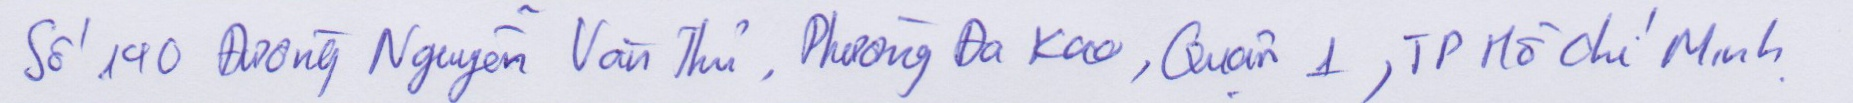

Số 140 Đường Nguyễn Văn Thủ, Phường Đa Kao, Quận 1, TP Hồ Chí Minh
0508_samples.png
[39, 118, 0, 11, 14, 10, 0, 90, 96, 124, 57, 51, 0, 34, 51, 64, 68, 112, 57, 0, 42, 89, 57, 0, 40, 52, 129, 6, 0, 36, 52, 96, 124, 57, 51, 0, 90, 46, 0, 31, 46, 58, 6, 0, 37, 64, 102, 57, 0, 11, 6, 0, 40, 36, 0, 28, 119, 0, 23, 52, 81, 0, 33, 53, 57, 52]


(103, 1853, 3)

In [ ]:
# check an img
index = 1213
img = cv2.imread(img_path[index])
cv2_imshow(img)
print(img_label[index])
print(os.path.basename(img_path[index]))
print(encode_to_labels(img_label[index]))
img.shape

# PREPROCESS DATA

In [ ]:
# find max label len for RNN sequence pad
label_list = []
for i in data_dict.values():
  label_list.append(len(i))
max_label_len = max(label_list)
max_label_len

69

In [ ]:
# split data
from sklearn.model_selection import train_test_split
train_img_path, val_img_path = train_test_split(img_path, test_size=0.2, random_state=17)

In [ ]:
# timestep need to greater than max label len to avoid extracting 
time_steps = 200

## PIPELINE

In [ ]:
import numpy as np
# train data
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
resize_max_width=0
for image in train_img_path:
    # read, convert greyscale, resize, blur, threshold, normalize
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    height, width = img.shape
    # in this dataset, we don't need to do any resize at all here.
    img = cv2.resize(img,(int(118/height*width),118))
    height, width = img.shape
    if img.shape[1] > resize_max_width:
        resize_max_width = img.shape[1]
    img = np.pad(img, ((0,0),(0, 2167-width)), 'median')
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    label = data_dict[image]
    orig_txt.append(label)   
    train_label_length.append(len(label))
    # set timesteps for input
    train_input_length.append(time_steps)
    training_img.append(img)
    # convert to digits for pad sequence
    training_txt.append(encode_to_labels(label)) 

In [ ]:
# valid data
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
for image in val_img_path:
    # read, convert greyscale, resize, blur, threshold, normalize
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(int(118/height*width),118))
    if img.shape[1] > resize_max_width:
        resize_max_width = img.shape[1]
    img = np.pad(img, ((0,0),(0, 2167-width)), 'median')
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    label = data_dict[image]
    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))
    # set timesteps for input
    valid_input_length.append(time_steps)
    valid_img.append(img)
    # convert to digits for pad sequence
    valid_txt.append(encode_to_labels(label))

In [ ]:
# padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_padded_txt = pad_sequences(training_txt, maxlen=time_steps, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=time_steps, padding='post', value = 0)

In [ ]:
train_padded_txt[0]

array([ 39, 118,   0,  12,   6,   0,  57,  51,  85,   0,  15,  13,   6,
         0,  59,  52, 118,   0,  32,  53,  57,  52,   0,  32,  46,  57,
        51,   6,   0,  36,  52,  96, 124,  57,  51,   0,  23, 118,  57,
        51,   0,  42, 115,   6,   0,  37,  64, 102,  57,   0,  22,  46,
         0,  90,  80,  57,  52,   6,   0,  28,  73,   0,  34, 122,  53,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## MODEL

In [ ]:
# import our model, different layers and activation function 
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D,  Activation, Add, BatchNormalization, LSTM, Lambda, Bidirectional,  Dense
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K

In [ ]:
# Input
inputs = Input(shape=(118,2167,1))
 
# layer 1
model = Conv2D(64, (3,3), padding='same')(inputs)
model = MaxPool2D(pool_size=3, strides=3)(model)
model = Activation('relu')(model)

# layer 2
model = Conv2D(128, (3,3), padding='same')(model)
model = MaxPool2D(pool_size=3, strides=3)(model)
model = Activation('relu')(model)

# layer 3
model = Conv2D(256, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
x = model

# layer 4
model = Conv2D(256, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Add()([model, x])
model = Activation('relu')(model)

# layer 5
model = Conv2D(512, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
x2 = model

# layer 6
model = Conv2D(512, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Add()([model, x2])
model = Activation('relu')(model)

# layer 7
model = Conv2D(1024, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D(pool_size=(3, 1))(model)
model = Activation('relu')(model)
model = MaxPool2D(pool_size=(3, 1))(model)
 
# remove the first dimension(1, 31, 512) to (31, 512) 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(model)
 
# RNN
blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 118, 2167,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 118, 2167, 6  640         ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 39, 722, 64)  0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
# CTC
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
# define ctc input
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])
# model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
# save model
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
filepath="/content/gdrive/MyDrive/Data_ML_Study/trained_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
model.summary()

In [ ]:
# convert to np 
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  
train_label_length = np.array(train_label_length)  
# convert to np
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) 
valid_label_length = np.array(valid_label_length) 

tcmalloc: large alloc 3007102976 bytes == 0xef38c000 @  0x7f7f2c5e81e7 0x7f7f1e1560ce 0x7f7f1e1b2715 0x7f7f1e1b2d1b 0x7f7f1e253333 0x5936cc 0x548c51 0x51566f 0x549576 0x604173 0x62a809 0x59358d 0x515244 0x598ef4 0x515a6e 0x598ef4 0x515a6e 0x598ef4 0x59afff 0x515655 0x593dd7 0x5118f8 0x593dd7 0x511e2c 0x549576 0x4bca8a 0x59c019 0x595ef6 0x5134a6 0x549e0e 0x593fce


In [ ]:
batch_size = 32
epochs = 100

history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, 
          callbacks = callbacks_list)

## Evaluation

In [ ]:
# load trained model
model = act_model.load_weights(os.path.join('/content/gdrive/MyDrive/Data_ML_Study/trained_model.hdf5'))

In [ ]:
prediction = act_model.predict(valid_img)

In [ ]:
# decode
decode = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1], greedy=True)[0][0])
all_predictions =[]
i = 0
for l in decode:
    print("Label: ", valid_orig_txt[i])
    print("Predicted: ", end = '')
    predict = ""
    for j in l:  
        if int(j) != -1:
            predict += char_list[int(j)]
    print(predict)
    all_predictions.append(predict)
    i+=1

In [ ]:
import string
import unicodedata
import editdistance

def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [ ]:
result = ocr_metrics(predicts=all_predictions, ground_truth=valid_orig_txt)
print(f'Result: \n CER: {result[0]} \n WER: {result[1]} \n SER: {result[2]}')

Result: 
 CER: 0.037506890288750865 
 WER: 0.12615342462489232 
 SER: 0.6929347826086957


## Demo

In [ ]:
import pickle
with open('charlist.txt', 'wb') as f:
  pickle.dump(char_list, f)

In [ ]:
import pickle
pickle_off = open ("charlist.txt", "rb")
emp = pickle.load(pickle_off)
print(emp)
len(emp)

In [ ]:
%%writefile demo.py
import streamlit as st
import numpy as np
import os
import pickle
import cv2
# import our model, different layers and activation function 
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D,  Activation, Add, BatchNormalization, LSTM, Lambda, Bidirectional,  Dense
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K

# Input
inputs = Input(shape=(118,2167,1))
 
# layer 1
model = Conv2D(64, (3,3), padding='same')(inputs)
model = MaxPool2D(pool_size=3, strides=3)(model)
model = Activation('relu')(model)

# layer 2
model = Conv2D(128, (3,3), padding='same')(model)
model = MaxPool2D(pool_size=3, strides=3)(model)
model = Activation('relu')(model)

# layer 3
model = Conv2D(256, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
x = model

# layer 4
model = Conv2D(256, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Add()([model, x])
model = Activation('relu')(model)

# layer 5
model = Conv2D(512, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
x2 = model

# layer 6
model = Conv2D(512, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Add()([model, x2])
model = Activation('relu')(model)

# layer 7
model = Conv2D(1024, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D(pool_size=(3, 1))(model)
model = Activation('relu')(model)
model = MaxPool2D(pool_size=(3, 1))(model)
 
# remove the first dimension(1, 31, 512) to (31, 512) 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(model)
 
# RNN
blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(141, activation = 'softmax')(blstm_2)
# model to be used at test time
act_model = Model(inputs, outputs)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Demo
st.title('OCR Demo')
upload_file = st.file_uploader('Select file')
if upload_file is not None:
    # Load char list
    pickle_off = open ("charlist.txt", "rb")
    char_list = pickle.load(pickle_off)
    #Demo img
    demo_img = []
    demo_txt = []
    demo_input_length = []
    demo_label_length = []
    demo_orig_txt = []
    # Convert the file to an opencv image.
    file_bytes = np.asarray(bytearray(upload_file.read()), dtype=np.uint8)
    opencv_image = cv2.imdecode(file_bytes, 1)
    # preprocess
    img = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
    height, width = img.shape
    img = cv2.resize(img,(2167,118))
    
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    demo_img.append(img)
    demo_img = np.array(demo_img)
    # load the saved best model weights
    act_model.load_weights(os.path.join('/content/gdrive/MyDrive/Data_ML_Study/trained_model.hdf5'))
    prediction = act_model.predict(demo_img)
    # use CTC decoder
    decode = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1], greedy=True)[0][0])
    # Display
    st.subheader("Your img")
    st.image(upload_file)
    st.subheader("After preprocessing")
    st.image(img)
    st.write('Predict string: ')
    # predict
    # see the results
    i = 0
    for l in decode:
        print("predicted text = ", end = '')
        predict = ""
        for j in l:  
            if int(j) != -1:
                predict += char_list[int(j)]
        st.write(predict)
        i+=1

Overwriting demo.py


In [ ]:
!streamlit run demo.py & npx localtunnel --port 8501

2022-06-07 05:48:40.506 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
npx: installed 22 in 2.408s
your url is: https://quiet-doodles-lie-35-196-100-81.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.196.100.81:8501

2022-06-07 05:48:52.699721: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
predicted text = predicted text = predicted text =   Stopping...
^C
